# Qats & Doqs
```
        |----------|  |------------|
        |  Sensor  |  | Classifier |    
        | |------| |  |  |------|  |              |---------|
        |-| S(x) |-|--|--| U(θ) |--|--------------| MEASURE |
        | |------| |  |  |------|  |              |---------|
        |----------|  |------------|                   |
  c0 --------------------------------------------------o-----
```

## Table of Contents
* [Classification North // South](#north_south)
* [Classification Eastern // Western](#east_west)

In [233]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Classification North // South <a class="anchor" id="north_south"></a>

### Sensor

In [161]:
@qml.template
def sensor(datas, wires):
    qml.RX(datas[0], wires=wires[0])
    if len(datas) == 3:
        qml.RY(datas[1], wires=wires[0])
        qml.RZ(datas[2], wires=wires[0])
    else:
        qml.RZ(datas[1], wires=wires[0])

### Classifier

In [162]:
@qml.template
def classifier(params, wires):
    # qml.RZ(params, wires=wires[0])
    # qml.RY(params, wires=wires[0])
    n_qubits = len(wires)
    n_rotations = len(params)
    n_layers = n_rotations // n_qubits

    if n_rotations % n_qubits != 0:
        raise Exception("Last layer is incomplete, not all qubits are rotated")

    # Alternating layers of unitary rotations on every qubit followed by a
    # ring cascade of CNOTs.
    for layer_idx in range(n_layers):
        layer_params = params[layer_idx * n_qubits: layer_idx * n_qubits + n_qubits, :]
        qml.broadcast(qml.Rot, wires, pattern="single", parameters=layer_params)
        if n_qubits > 1:
            qml.broadcast(qml.CNOT, wires, pattern="ring")

### Init data sensor

In [163]:
"""
   To use your dataset just change the csv file call 
"""
csv_training = pd.read_csv('datas/training_data_xz.csv', header=None)
print("Training data set shape", csv_training.shape)
print("Training data set:") 
print(csv_training[:10])
print("\n")

csv_testing = pd.read_csv('datas/testing_data_xz.csv', header=None)
print("Testing data set shape", csv_testing.shape)
print("Testing data set:") 
print(csv_testing[:10])

"""
   To use your dataset just change the csv file call 
"""
#csv_training = pd.read_csv('datas/training_data_xyz_normal.csv', header=None)
#print("Training data set shape", csv_training.shape)
#print("Training data set:") 
#print(csv_training[:10])
#print("\n")

#csv_testing = pd.read_csv('datas/testing_data_xyz_normal.csv', header=None)
#print("Testing data set shape", csv_testing.shape)
#print("Testing data set:") 
#print(csv_testing[:10])

Training data set shape (1999, 3)
Training data set:
          0         1    2
0  1.310305  5.265838  qat
1  1.807496  4.473977  doq
2  1.828074  4.368759  doq
3  2.250279  2.510487  doq
4  0.809598  1.625995  qat
5  0.835273  3.986925  qat
6  1.596440  5.485240  doq
7  0.917452  0.198001  qat
8  0.761617  4.235470  qat
9  1.333237  1.454580  qat


Testing data set shape (499, 2)
Testing data set:
          0         1
0  1.796278  5.127016
1  0.220950  5.766171
2  0.736258  5.166474
3  0.508544  0.854920
4  3.028223  2.815891
5  0.311861  5.269300
6  2.295929  0.453769
7  1.340906  1.582118
8  0.557699  5.657507
9  3.121631  5.701430


'\n   To use your dataset just change the csv file call \n'

### Training

In [ ]:
print("##################################################################\n"
      "# TRAINING")
"""
    Variables :
    data_training : the xy // xyz data for only 1 qubit
    label_training : the label for only 1 qubit
    n_layers : deep level
    weights : the angle for the classifier
    wires : number of qubits for the classifier
    shots : number of shots
    error_rate : number of error
    circuit_run : number of circuit loop
    optimizer_run : number of optimizer iteration
"""

dev = qml.device('default.qubit', wires=1, shots=1)
n_qubits = len(dev.wires)
n_layers = 2
weights = np.random.uniform(low=-np.pi, high=np.pi, size=(n_layers * n_qubits, 3))
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# Stats var
error_rate = 0
circuit_run = 0
optimizer_run = 0

if csv_training.shape[1] == 3:
    prediction = [[], [], []]
elif csv_training.shape[1] == 4:
    prediction = [[], [], [], []]
else:
    print("Only two or three angles are allowed in training data set")

for i in range(len(csv_training[0])):
#for i in range(50):
    if csv_training.shape[1] == 3:
        data_training = [csv_training[0][i], csv_training[1][i]]
        label_training = csv_training[2][i]
    elif csv_training.shape[1] == 4:
        data_training = [csv_training[0][i], csv_training[1][i], csv_training[2][i]]
        label_training = csv_training[3][i]
    else:
        print("Only two or three angles are allowed in training data set")


    @qml.qnode(dev)
    def entire_circuit(datas, params):
        sensor(datas, wires=[0])
        classifier(params, wires=dev.wires)
        return qml.sample(qml.PauliZ(0))
    
    def count_prob(result):
        prob_qat = 0
        prob_doq = 0
        if dev.shots > 1:
            for i in result:
                if i == 1:
                    prob_qat += 1
                else:
                    prob_doq += 1
            if prob_qat > prob_doq:
                prob = 1
            elif prob_qat == prob_doq:
                prob = 0
            else:
                prob = -1
        else:
            prob = result
        return prob
    
    @qml.qnode(dev)
    def optimizer_circuit(params):
        classifier(params, wires=dev.wires)
        return qml.expval(qml.PauliZ(0))
    
    def cost(x):
        return optimizer_circuit(x)
    
    # Run a first time the entire circuit
    result = entire_circuit(data_training, weights)
    prob = count_prob(result)
    circuit_run += 1
    
    # Optimize th weights is the output is bad
    if (prob == -1 and label_training != "doq") or (prob == 1 and label_training != "qat"):
        steps = 100
        for u in range(steps):
            weights = opt.step(cost, weights)
            result = entire_circuit(data_training, weights)
            prob = count_prob(result)
            circuit_run += 1
            optimizer_run += 1
            
            if (u + 1) % 10 == 0:
                print("Cost after step {:5d}: {: .7f} -> {}".format(u + 1, prob, label_training))
                      
            if (prob == -1 and label_training == "doq") or (prob == 1 and label_training == "qat"):
                break
    
    # Calculate error rate
    if (prob == -1 and label_training != "doq") or (prob == 1 and label_training != "qat"):
        error_rate += 1
    
    print("Run for data number : ", i+1)
        
    # Graph and check error
    prediction[0].append(data_training[0])
    prediction[1].append(data_training[1])
    if csv_training.shape[1] == 3:
        prediction[2].append(prob)
    else:
        prediction[2].append(data_training[2])
        prediction[3].append(prob)

print("\nTraining done !")

### Graph and check error

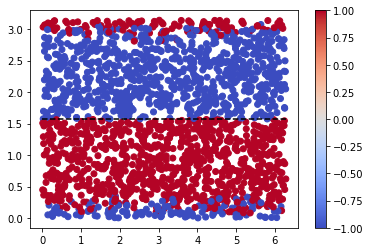

Error rate : 12.156 %

Resources used for 1999 datas : 
Circuit run : 44538, Optimize run : 42539, Deph 2, Shot(s) : 1, Qubit(s) : 1


In [172]:
if len(prediction) == 3:
    plt.scatter(prediction[1], prediction[0], c=prediction[2], cmap="coolwarm")
    plt.plot([0,2*np.pi], [np.pi/2, np.pi/2], linestyle='--', c='#000000')
    plt.colorbar()
elif len(prediction) == 4:
    fig = plt.figure().gca(projection='3d')
    fig.scatter(prediction[0], prediction[1], prediction[2], c=prediction[3], cmap="coolwarm")
plt.show()

print("Error rate : {} %".format(round(error_rate / len(prediction[0]) * 100, 3)))
print("\nResources used for {} datas : \nCircuit run : {}, Optimize run : {}, Deph {}, Shot(s) : {}, Qubit(s) : {}"
      .format(len(prediction[0]), circuit_run, optimizer_run, n_layers, dev.shots, n_qubits))

### Testing

In [208]:
print("##################################################################\n"
      "# Testing")
"""
    Variables :
    data_training : the xy // xyz data for only 1 qubit
    label_training : the label for only 1 qubit
    n_layers : deep level
    weights : the angle for the classifier
"""

dev = qml.device('default.qubit', wires=1, shots=1)

if csv_testing.shape[1] == 2:
    prediction = [[], [], []]
else:
    prediction = [[], [], [], []]

for i in range(len(csv_testing[0])):
#for i in range(20):
    if csv_testing.shape[1] == 2:
        data_testing = [csv_testing[0][i], csv_testing[1][i]]
    else:
        data_testing = [csv_testing[0][i], csv_testing[1][i], csv_testing[2][i]]


    @qml.qnode(dev)
    def entire_circuit(datas, params):
        sensor(datas, wires=[0])
        classifier(params, wires=dev.wires)
        return qml.sample(qml.PauliZ(0))
    
    # Run the circuit
    result = entire_circuit(data_testing, weights)
    prob = result
        
    
    # Graph and check error
    prediction[0].append(data_testing[0])
    prediction[1].append(data_testing[1])
    if csv_testing.shape[1] == 2:
        prediction[2].append(prob)
    else:
        prediction[2].append(data_testing[2])
        prediction[3].append(prob)

print("\nTesting done !")

##################################################################
# Testing

Testing done !


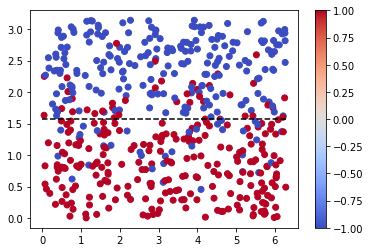

In [210]:
if len(prediction) == 3:
    plt.scatter(prediction[1], prediction[0], c=prediction[2], cmap="coolwarm")
    plt.plot([0,2*np.pi], [np.pi/2, np.pi/2], linestyle='--', c='#000000')
    plt.colorbar()
else:
    fig = plt.figure().gca(projection='3d')
    fig.scatter(prediction[0], prediction[1], prediction[2], c=prediction[3], cmap="coolwarm")
plt.show()

## Classification Eastern // Western <a class="anchor" id="east_west"></a>

### Sensor

In [244]:
def circuit(x, wires):
    n_qubits = len(wires)
    n_rotations = len(x)

    if n_rotations != n_qubits:
        raise Exception("Not all qubits are rotated")

    for i in range(n_qubits):
        qml.RX(x[i,0], wires=i)
        qml.RY(x[i,1], wires=i)


def get_labelled_dataset(wires, how_many):
    n_qubits = len(wires)

    X = np.random.uniform(low=-np.pi, high=np.pi, size=(how_many, n_qubits, 2)) # data vectors
    Y = np.ones(how_many) # labels, 1 means Qat, -1 means DoQ

    for i in range(how_many):
        x = X[i]

        n_east = 0
        n_west = 0
        for j in range(n_qubits):
            if x[j,0] <= 0.0:
                n_east += 1
            else:
                n_west += 1

        # majority voting
        if n_west > n_east:
            Y[i] = -1

    return X, Y


if __name__ == "__main__":
    dev = qml.device("default.qubit", wires=range(3))

    @qml.qnode(dev)
    def my_circuit(x, wires):
        circuit(x, wires)
        return qml.expval(qml.PauliY(0))    

    X, Y = get_labelled_dataset(dev.wires, 5)
    print(X)
    print(Y)
    
    drawer = qml.draw(my_circuit)
    print(drawer(X[0], dev.wires))

    x = np.array([[-np.pi/2, 0.0], [0, 0], [0, 0]], dtype=np.float64)
    print(my_circuit(x, dev.wires))

[[[ 2.252836    2.55397878]
  [-1.07130833 -2.8718778 ]
  [ 2.12241367  0.77353463]]

 [[-0.67611058 -1.04942073]
  [ 2.86509505  2.76755527]
  [ 2.85725262  2.45337127]]

 [[ 0.26138472  0.87100689]
  [-1.09808194  0.73354333]
  [-1.68260925  0.3653917 ]]

 [[-0.86196887 -2.92907853]
  [-0.21279506  0.57853884]
  [ 1.52798912  0.44389097]]

 [[ 0.65358405 -2.36718398]
  [-2.56269716  0.47618745]
  [-0.84242617  0.11314753]]]
[-1. -1.  1.  1.  1.]
 0: ──RX(2.25)───RY(2.55)───┤ ⟨Y⟩ 
 1: ──RX(-1.07)──RY(-2.87)──┤     
 2: ──RX(2.12)───RY(0.774)──┤     

0.9999999999999998


### Classifier

In [245]:
def classifier_ciruit(weights, wires):
    n_qubits = len(wires)
    n_rotations = len(weights)
    n_layers = n_rotations // n_qubits

    if n_rotations % n_qubits != 0:
        raise Exception("Last layer is incomplete, not all qubits are rotated")

    for i in range(n_layers):
        for j in range(n_qubits):
            # single-qubit rotations
            qml.RX(weights[i*n_qubits+j,0], wires=j)
            qml.RY(weights[i*n_qubits+j,1], wires=j)
            qml.RZ(weights[i*n_qubits+j,2], wires=j)

        if n_qubits > 1:
            # engtangling gates
            qml.broadcast(qml.CNOT, wires, pattern="ring")


def get_initial_weights(wires, n_layers):
    n_qubits = len(wires)
    return np.random.uniform(low=-np.pi, high=np.pi, size=(n_layers * n_qubits, 3))


if __name__ == "__main__":
    dev = qml.device("default.qubit", wires=range(3))

    @qml.qnode(dev)
    def my_circuit(weights, wires):
        circuit(weights, wires)
        return qml.expval(qml.PauliZ(0))    

    n_layers = 2
    weights = get_initial_weights(dev.wires, n_layers)
    print(weights)
    
    drawer = qml.draw(my_circuit)
    print(drawer(weights, wires=dev.wires))

[[ 0.77136755  0.29379178  0.45999567]
 [-2.22070706 -2.91729397  1.76307883]
 [ 1.49362903 -2.08813086 -2.10381087]
 [-1.11162881  0.85748347 -2.99133083]
 [-3.09295273 -1.7505905   2.27422382]
 [ 2.47962988 -2.27162838  1.25539716]]
 0: ──RX(0.771)──RY(0.294)──┤ ⟨Z⟩ 
 1: ──RX(-2.22)──RY(-2.92)──┤     
 2: ──RX(1.49)───RY(-2.09)──┤     



In [246]:
def combined_expval(weights, x, wires):
    circuit(x, range(1))
    classifier_ciruit(weights, wires)

    # create PauliZ ⊗ ... ⊗ PauliZ
    op = qml.PauliZ(0)
    for i in range(1, len(wires)):
        op = op @ qml.PauliZ(i)

    return qml.expval(op)


def combined_1shot(weights, x, wires):
    circuit(x, range(1))
    classifier_ciruit(weights, wires)

    # create PauliZ ⊗ ... ⊗ PauliZ
    op = qml.PauliZ(0)
    for i in range(1, len(wires)):
        op = op @ qml.PauliZ(i)

    return qml.sample(op)


def get_data_and_weights(wires, n_layers, how_many):
    X, Y = get_labelled_dataset(range(1), how_many)
    weights = get_initial_weights(wires, n_layers)
    return X, Y, weights


if __name__ == "__main__":
    dev_expval = qml.device("default.qubit", wires=range(3))
    print(dev_expval)

    dev_1shot = qml.device("default.qubit", wires=range(3), shots=1)
    print(dev_1shot)

    @qml.qnode(dev_expval)
    def my_combined_expval(weights, x, wires):
        return combined_expval(weights, x, wires)

    @qml.qnode(dev_1shot)
    def my_combined_1shot(weights, x, wires):
        return combined_1shot(weights, x, wires)

    X, Y, weights = get_data_and_weights(dev_expval.wires, 2, 5)
    print(X)
    print(Y)
    print(weights)

    drawer = qml.draw(my_combined_expval)
    print(drawer(weights, X[0], wires=dev_expval.wires))

    # expval classifier output for sensor data x (weights were not optimized)
    print(my_combined_expval(weights, X[0], wires=dev_expval.wires))

    # 1shot classifier output for sensor data x (weights were not optimized)
    print(my_combined_1shot(weights, X[0], wires=dev_1shot.wires))

Default qubit PennyLane plugin
Short name: default.qubit
Package: pennylane
Plugin version: 0.14.0
Author: Xanadu Inc.
Wires: 3
Shots: 1000
Default qubit PennyLane plugin
Short name: default.qubit
Package: pennylane
Plugin version: 0.14.0
Author: Xanadu Inc.
Wires: 3
Shots: 1
[[[-1.70752677  1.70630918]]

 [[-2.86573288  0.06689167]]

 [[ 2.37308623 -0.44621281]]

 [[ 2.90476298 -2.49134021]]

 [[-0.49568646  1.22637239]]]
[ 1.  1. -1. -1.  1.]
[[-1.9533531   2.81208544  0.26297472]
 [ 2.76419656  0.53136092  1.99972781]
 [-1.27478559  1.07823477  1.93467671]
 [ 1.52040562  1.14123599 -2.84703073]
 [-0.4109579  -2.115363    0.79265111]
 [ 2.13240705  2.71106035  2.19528826]]
 0: ──RX(-1.71)──RY(1.71)───RX(-1.95)──RY(2.81)──RZ(0.263)──╭C──────────────────╭X──RX(1.52)───RY(1.14)───RZ(-2.85)──╭C──────╭X──╭┤ ⟨Z ⊗ Z ⊗ Z⟩ 
 1: ──RX(2.76)───RY(0.531)──RZ(2)───────────────────────────╰X──╭C──RX(-0.411)──│───RY(-2.12)──RZ(0.793)─────────────╰X──╭C──│───├┤ ⟨Z ⊗ Z ⊗ Z⟩ 
 2: ──RX(-1.27)──RY(1.08)─

### Training

In [247]:
n_qubits = 1 ### Number of qubits in classifier, change it as you wish. Sensor will ALWAYS use only 1st qubit
n_shots = 30 ### This is for TRAINING (to calculate expected values), for testing see shots below

dev_expval = qml.device("default.qubit", wires=range(n_qubits), analytic=False, shots=n_shots)
print(dev_expval)


@qml.qnode(dev_expval)
def combined_expval_train(weights, x, wires):
    return combined_expval(weights, x, wires)


def k_power_loss(labels, predictions, k):
    loss = 0.0
    for l, p in zip(labels, predictions):
        #print(p)
        loss += np.abs(l - p) ** k
    loss = loss / len(labels)
    return loss


def cost(weights, wires, X, Y, k):
    predictions = [combined_expval_train(weights, x, wires=wires) for x in X]
    return k_power_loss(Y, predictions, k)


def train(weights, wires, X, Y, steps, batch_size, k):
    #opt = qml.GradientDescentOptimizer(0.1)
    opt = qml.NesterovMomentumOptimizer(0.1)

    for _ in range(steps):
        batch_idx = np.random.randint(0, len(X), (batch_size,))

        X_batch = X[batch_idx]
        Y_batch = Y[batch_idx]

        weights, prev_cost = opt.step_and_cost(lambda weights: cost(weights, wires, X_batch, Y_batch, k), weights)
        print(prev_cost)
        #print(weights)

    opt_cost = cost(weights, wires, X, Y, k)
    print(opt_cost)

    return weights


if __name__ == "__main__":
    np.random.seed(0) ### This ensures results are reproducible

    n_layers = 1 ### number of layers, more than 1 makes sense when n_qubits > 1, or we use data re-upload
    how_many = 500 ### size of training set, random points on Bloch sphere
    X, Y, weights = get_data_and_weights(dev_expval.wires, n_layers, how_many)
    #print(X)
    #print(Y)
    print(weights)

    drawer = qml.draw(combined_expval_train)
    #print(drawer(weights, X[0], wires=dev_expval.wires))

    k = 1 ### power in cost function, 1 is the best, surprisingly
    steps = 50
    batch_size = 10
    opt_weights = train(weights, dev_expval.wires, X, Y, steps, batch_size, k)
    #print(opt_weights)
    
    drawer = qml.draw(combined_expval_train) ### Sensor has RX and RY gates, then each classifier layer has RX, RY, and RZ, plus CNOTS (if n_qubits > 1)
    #print(drawer(opt_weights, X[0], wires=dev_expval.wires))

    #
    # Accuracy on unseen test set
    #
    X_test, Y_test, not_used = get_data_and_weights(dev_expval.wires, n_layers, 1000) ### test set has 1000 items
    
    acc_n_shots = 1 ### 1-shot results, change to 30, or 1000, to get results when multiple shots are possible during operation
    dev_acc_expval = qml.device("default.qubit", wires=range(n_qubits), analytic=False, shots=acc_n_shots)
    
    @qml.qnode(dev_acc_expval)
    def acc_combined_expval_train(weights, x, wires):
        return combined_expval(weights, x, wires)

    predictions = [acc_combined_expval_train(opt_weights, x, wires=dev_acc_expval.wires) for x in X_test]
    #print(dev_acc_expval.state)

    correct_predictions = 0
    for i in range(len(X_test)):
        if (predictions[i] >= 0.0 and Y_test[i] == 1) or (predictions[i] < 0.0 and Y_test[i] == -1):
            correct_predictions += 1

    accuracy = correct_predictions / len(Y_test)
    print(accuracy)

Default qubit PennyLane plugin
Short name: default.qubit
Package: pennylane
Plugin version: 0.14.0
Author: Xanadu Inc.
Wires: 1
Shots: 30
[[ 0.58358395 -3.07836059 -0.15188849]]
1.4466666666666665
1.2999999999999998
1.2533333333333334
1.1466666666666667
0.8733333333333333
1.16
0.7533333333333333
0.6
0.4866666666666667
0.4866666666666667
0.2733333333333333
0.5933333333333334
0.45999999999999996
0.27999999999999997
0.5066666666666666
0.4066666666666666
0.8
0.6066666666666667
0.45999999999999996
0.3666666666666666
0.2
0.2666666666666667
0.4333333333333334
0.38666666666666666
0.3666666666666667
0.13999999999999999
0.4866666666666667
0.4333333333333334
0.3
0.48666666666666664
0.26666666666666666
0.36000000000000004
0.30666666666666664
0.23333333333333334
0.4
0.31999999999999995
0.4933333333333333
0.26000000000000006
0.3133333333333333
0.44000000000000006
0.32666666666666677
0.3333333333333333
0.5533333333333333
0.30666666666666664
0.4133333333333333
0.5666666666666667
0.26666666666666666
0.